In [ ]:
import os
directory = os.path.dirname(os.getcwd())
import sys
sys.path.append(directory)

In [ ]:
import lxml
import src.data as data

# Variables

In [ ]:
DIRECTORY_DATA = os.path.join(directory, 'data')
DIRECTORY_OUTPUT = os.path.join(DIRECTORY_DATA,'01')

# Parsing Dataset

In [4]:
dblp = data.DatasetDBLP(directory_output=DIRECTORY_OUTPUT)
filepath = os.path.join(DIRECTORY_DATA, 'dblp.xml')
print(filepath)
dblp.from_file(filepath)

In [ ]:
dblp.parse_data()

In [ ]:
idx = dict(dblp.entities_idx_by_key)

In [ ]:
idx.keys()

In [ ]:
idx['title']

In [ ]:
conferences = [k for k in idx['inproceedings'].keys() if 'sigmod' in k.lower()]

In [ ]:
conferences_idx = []
for k in conferences:
    conferences_idx += idx['inproceedings'][k]

In [ ]:
uid = dblp.uid
with open(os.path.join(DIRECTORY_OUTPUT, 'inproceedings_' + uid + '.pkl'), 'rb') as f:
    entities = pickle.load(f)

In [ ]:
uid = dblp.uid
with open(os.path.join(DIRECTORY_OUTPUT, 'title_' + uid + '.pkl'), 'rb') as f:
    titles = pickle.load(f)

In [ ]:
title = titles[200]

In [ ]:
title

In [ ]:
example = entities[1340364]

In [ ]:
example

In [ ]:
conferences_idx

In [ ]:
len(conferences)

In [ ]:
import pickle
uid = dblp.uid
with open(os.path.join(DIRECTORY_OUTPUT, ('entities_idx_by_tag' + '_' + uid + '.pkl')), 'wb') as f:
    dictionary = dict(dblp.entities_idx_by_tag)
    pickle.dump(dictionary, f)
    
with open(os.path.join(DIRECTORY_OUTPUT, ('entities_idx_by_key' + '_' + uid + '.pkl')), 'wb') as f:
    dictionary = dict(dblp.entities_idx_by_key)
    pickle.dump(dictionary, f)
    
with open(os.path.join(DIRECTORY_OUTPUT, ('attributes_by_tag' + '_' + uid + '.pkl')), 'wb') as f:
    dictionary = dict(dblp.attributes_by_tag)
    pickle.dump(dictionary, f)
    
with open(os.path.join(DIRECTORY_OUTPUT, ('relationships_by_tag' + '_' + uid + '.pkl')), 'wb') as f:
    dictionary = dict(dblp.relationships_by_tag)
    pickle.dump(dictionary, f)
    


# Loading Data

In [ ]:
len(dblp.entities_idx_by_tag['article'])

In [ ]:
import datetime

import hashlib


hashlib.sha256(str(datetime.datetime.now().timestamp()).encode('utf-8')).hexdigest()

In [ ]:
0 % 10000

# Adhoc

In [5]:
from collections import defaultdict
i = 0
elements = []
titles = []
titles_by_date = defaultdict(list)
all_elements = ['inproceedings']
for event, element in dblp.data:
    if element.tag in all_elements:
        
        if 'sigmod' in element.items()[1][1].lower():
            elements.append(element)
            for sub in element:
                if sub.tag == 'title':
                    t = sub.text
                if sub.tag == 'year':
                    d = sub.text
            titles.append(t)
            titles_by_date[d].append(t)

# Descriptive

### inproceedings count per year

<Axes: xlabel='year'>

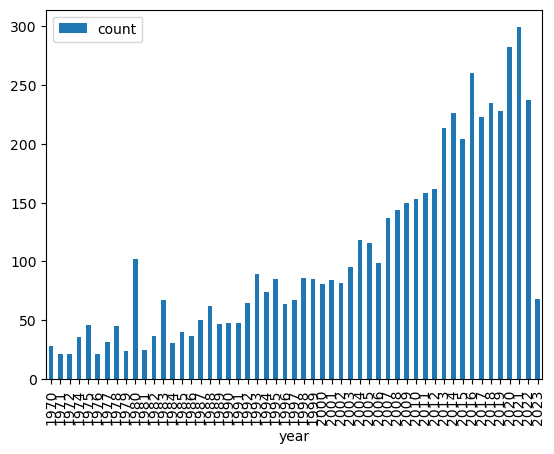

In [18]:
import pandas as pd

tmp = []
for k, v in titles_by_date.items():
    tmp.append([k, len(v)])
df = pd.DataFrame(tmp, columns=['year', 'count'])
df.sort_values('year', inplace=True)
df.plot.bar('year', 'count')

### title length statistics by year

In [57]:
import statistics
import numpy as np
tmp = []
y = []
for k, v in titles_by_date.items():
    lengths = []
    for t in v:
        if not t is None:
            lengths.append(len(t.split(' ')))
    
    tmp.append( {'label': k,'whislo':min(lengths), 'whishi':max(lengths), 'med':statistics.median(lengths), 'q1':np.percentile(lengths, 25), 'q3':np.percentile(lengths, 75)})
    y.append(k)
    
tmp = sorted(tmp, key=lambda x: x['label'])
#df = pd.DataFrame(tmp, columns=['year', 'min', 'max', 'med', '25', '75'])
#df.sort_values('year', inplace=True)
y = sorted(y)

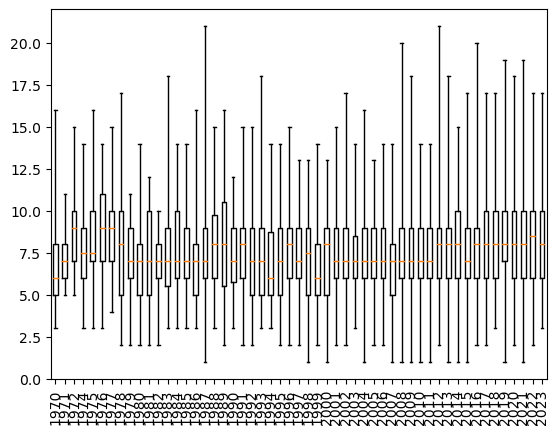

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1)
ax.bxp(tmp, showfliers=False)
ax.set_xticks(ticks=range(1, len(y)+1),labels=y, rotation=90)

### tokenize titles and remove stop words

In [67]:
titles[:10]

['Bao: Making Learned Query Optimization Practical.',
 'Comments on Advantages of the Data-Structure-Set-Model.',
 'DB4ML - An In-Memory Database Kernel with Machine Learning Support.',
 'Generalized scale independence through incremental precomputation.',
 'Dynamically optimizing queries over large scale data platforms.',
 'Time-parameterized queries in spatio-temporal databases.',
 'SuperSQL: An Extended SQL for Database Publishing and Presentation.',
 'Event processing with an oracle database.',
 'Skew handling techniques in sort-merge join.',
 'Pinot: Realtime OLAP for 530 Million Users.']

In [143]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.util import ngrams

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
import string

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


### top 10 unigrams

In [131]:
sw = set(stopwords.words("english") + list(string.punctuation))
counts = defaultdict(lambda:defaultdict(int))
for k, v in titles_by_date.items():
    for t in v:
        if t:
            tokens = [word for word in word_tokenize(t) if not word in sw]
            for tok in tokens:
                counts[k][tok] += 1

In [132]:
topten = dict()
for k, v in counts.items():
    _ = [[k,v] for k,v in v.items()]
    _ = sorted(_,key=lambda x: x[1],reverse=True)
    top = _[:10]
    topten[k] = top

In [133]:
topten

{'2021': [['Data', 67],
  ['A', 48],
  ['Learning', 26],
  ['Graph', 25],
  ['Queries', 20],
  ['Query', 16],
  ['Efficient', 16],
  ['Systems', 15],
  ['Graphs', 15],
  ['Distributed', 14]],
 '1974': [['Data', 24],
  ['A', 12],
  ['Base', 8],
  ['Relational', 7],
  ['Management', 5],
  ['System', 5],
  ['The', 5],
  ['File', 4],
  ['Translation', 3],
  ['Model', 3]],
 '2020': [['Data', 68],
  ['A', 41],
  ['Queries', 26],
  ['Learning', 25],
  ['Database', 20],
  ['Graph', 19],
  ['Query', 17],
  ['Search', 16],
  ['System', 16],
  ['Analysis', 13]],
 '2013': [['data', 59],
  ['graph', 18],
  ['query', 16],
  ['using', 14],
  ['processing', 14],
  ['system', 14],
  ['database', 12],
  ['queries', 12],
  ['analytics', 11],
  ['big', 11]],
 '2014': [['data', 53],
  ['query', 21],
  ['queries', 17],
  ['Data', 17],
  ['A', 15],
  ['processing', 15],
  ['databases', 13],
  ['graphs', 12],
  ['Graph', 10],
  ['using', 10]],
 '2002': [['data', 20],
  ['queries', 11],
  ['database', 11],
  [

### top 10 bigrams

In [134]:
sw = set(stopwords.words("english") + list(string.punctuation))
counts_bigrams = defaultdict(lambda:defaultdict(int))
for k, v in titles_by_date.items():
    for t in v:
        if t:
            tokens = [word for word in word_tokenize(t) if not word in sw]
            ngs = ngrams(tokens,2)
            for gram in ngs:
                counts_bigrams[k][TreebankWordDetokenizer().detokenize(gram)] += 1

In [137]:
toptenbigrams = dict()
for k, v in counts_bigrams.items():
    _ = [[k,v] for k,v in v.items()]
    _ = sorted(_,key=lambda x: x[1],reverse=True)
    top = _[:10]
    toptenbigrams[k] = top

In [138]:
toptenbigrams

{'2021': [['Machine Learning', 10],
  ['Data Analysis', 4],
  ['Data Management', 4],
  ['Learning Systems', 4],
  ['Differentially Private', 4],
  ['Cardinality Estimation', 4],
  ['Query Processing', 4],
  ['Deep Learning', 4],
  ['Database Systems', 3],
  ['Learning Pipelines', 3]],
 '1974': [['Data Base', 8],
  ['Relational Data', 4],
  ['The Relational', 3],
  ['Data Management', 3],
  ['Comments Advantages', 2],
  ['Base Management', 2],
  ['A Data', 2],
  ['Data Description', 2],
  ['Description Language', 2],
  ['Management System', 2]],
 '2020': [['Machine Learning', 8],
  ['A System', 5],
  ['Interactive Data', 5],
  ['Big Data', 4],
  ['Data Analysis', 4],
  ['A Framework', 4],
  ['Stream Processing', 4],
  ['Query Processing', 3],
  ['Data Lakes', 3],
  ['Web Data', 3]],
 '2013': [['big data', 9],
  ['data streams', 4],
  ['data management', 4],
  ['query processing', 3],
  ['data analytics', 3],
  ['graph databases', 3],
  ['social networks', 3],
  ['data processing', 3],


### top 10 trigrams

In [139]:
sw = set(stopwords.words("english") + list(string.punctuation))
counts_trigrams = defaultdict(lambda:defaultdict(int))
for k, v in titles_by_date.items():
    for t in v:
        if t:
            tokens = [word for word in word_tokenize(t) if not word in sw]
            ngs = ngrams(tokens,3)
            for gram in ngs:
                counts_trigrams[k][TreebankWordDetokenizer().detokenize(gram)] += 1

In [140]:
toptentrigrams = dict()
for k, v in counts_trigrams.items():
    _ = [[k,v] for k,v in v.items()]
    _ = sorted(_,key=lambda x: x[1],reverse=True)
    top = _[:10]
    toptentrigrams[k] = top

In [141]:
toptentrigrams

{'2021': [['Machine Learning Pipelines', 2],
  ['Exploratory Data Analysis', 2],
  ['Event Stream Processing', 2],
  ['An Experimental Study', 2],
  ['Database Management Systems', 2],
  ['Graph Convolutional Networks', 2],
  ['Machine Learning Systems', 2],
  ['Distributed Machine Learning', 2],
  ['Machine Learning Training', 2],
  ['Graph Neural Networks', 2]],
 '1974': [['Relational Data Management', 3],
  ['Data Base Management', 2],
  ['A Data Description', 2],
  ['Data Description Language', 2],
  ['Data Management System', 2],
  ['The Relational Network', 2],
  ['Relational Network Approaches', 2],
  ['Title Workshop Committee', 2],
  ['Workshop Committee Editor', 2],
  ["Committee Editor's", 2]],
 '2020': [['Approximate Nearest Neighbor', 2],
  ['Nearest Neighbor Search', 2],
  ['Large Directed Graphs', 2],
  ['Context-Free Path Querying', 2],
  ['Minimization Classifier Construction', 2],
  ['Classifier Construction Cost', 2],
  ['Key-Value Storage Engines', 2],
  ['Stream Pr

### Nouns only

In [144]:
sw = set(stopwords.words("english") + list(string.punctuation))
counts_nouns = defaultdict(lambda:defaultdict(int))
for k, v in titles_by_date.items():
    for t in v:
        if t:
            tokens = word_tokenize(t)
            tokens = nltk.pos_tag(tokens)
            tokens = [word[0] for word in tokens if ((not word[0] in sw) and (word[1]=='NN'))]
            for tok in tokens:
                counts_nouns[k][tok] += 1

In [145]:
toptennouns = dict()
for k, v in counts_nouns.items():
    _ = [[k,v] for k,v in v.items()]
    _ = sorted(_,key=lambda x: x[1],reverse=True)
    top = _[:10]
    toptennouns[k] = top

In [146]:
toptennouns

{'2021': [['System', 5],
  ['Storage', 3],
  ['learning', 3],
  ['Approach', 3],
  ['serverless', 2],
  ['Scaling', 2],
  ['training', 2],
  ['edge', 2],
  ['influence', 2],
  ['maximization', 2]],
 '1974': [['Processing', 1],
  ['Information', 1],
  ['View', 1],
  ['Declaration', 1],
  ['Methodology', 1],
  ['Approach', 1],
  ['SEQUEL', 1],
  ['replacement', 1],
  ['Architecture', 1],
  ['Equivalence', 1]],
 '2020': [['learning', 6],
  ['System', 5],
  ['query', 5],
  ['Analysis', 4],
  ['processing', 3],
  ['machine', 3],
  ['knowledge', 2],
  ['graph', 2],
  ['Cost', 2],
  ['Processing', 2]],
 '2013': [['query', 14],
  ['system', 14],
  ['graph', 13],
  ['processing', 12],
  ['database', 12],
  ['analysis', 10],
  ['management', 9],
  ['mining', 9],
  ['search', 8],
  ['cloud', 7]],
 '2014': [['query', 19],
  ['processing', 14],
  ['graphs', 12],
  ['search', 10],
  ['graph', 9],
  ['database', 8],
  ['framework', 6],
  ['data', 5],
  ['optimization', 5],
  ['approach', 5]],
 '2002'

### top 10 bigram nouns

In [147]:
sw = set(stopwords.words("english") + list(string.punctuation))
counts_bigrams_nouns = defaultdict(lambda:defaultdict(int))
for k, v in titles_by_date.items():
    for t in v:
        if t:
            tokens = word_tokenize(t)
            tokens = nltk.pos_tag(tokens)
            tokens = [word[0] for word in tokens if ((not word[0] in sw) and (word[1]=='NN'))]
            ngs = ngrams(tokens,2)
            for gram in ngs:
                counts_bigrams_nouns[k][TreebankWordDetokenizer().detokenize(gram)] += 1

In [148]:
toptenbigramnouns = dict()
for k, v in counts_bigrams_nouns.items():
    _ = [[k,v] for k,v in v.items()]
    _ = sorted(_,key=lambda x: x[1],reverse=True)
    top = _[:10]
    toptenbigramnouns[k] = top

In [149]:
toptenbigramnouns

{'2021': [['influence maximization', 2],
  ['Bao Making', 1],
  ['serverless farm', 1],
  ['farm management', 1],
  ['iTurboGraph Scaling', 1],
  ['EIRES Integration', 1],
  ['training algorithms', 1],
  ['blockchain offloading', 1],
  ['offloading edge', 1],
  ['PyExplore Query', 1]],
 '2020': [['machine learning', 3],
  ['knowledge graph', 2],
  ['schema knowledge', 1],
  ['graph leveraging', 1],
  ['leveraging knowledge', 1],
  ['graph taxonomy', 1],
  ['taxonomy learning', 1],
  ['language processing', 1],
  ['processing enterprise', 1],
  ['Cost Processing', 1]],
 '2013': [['query processing', 3],
  ['bisimulation graphs', 2],
  ['query optimization', 2],
  ['labeling scheme', 2],
  ['independence precomputation', 1],
  ['similarity-search distance', 1],
  ['GraphBuilder graph', 1],
  ['graph framework', 1],
  ['QUBLE blending', 1],
  ['blending subgraph', 1]],
 '2014': [['query processing', 7],
  ['similarity search', 3],
  ['community detection', 2],
  ['behavior modeling', 2],


### top 10 trigram nouns

In [151]:
sw = set(stopwords.words("english") + list(string.punctuation))
counts_trigrams_nouns = defaultdict(lambda:defaultdict(int))
for k, v in titles_by_date.items():
    for t in v:
        if t:
            tokens = word_tokenize(t)
            tokens = nltk.pos_tag(tokens)
            tokens = [word[0] for word in tokens if ((not word[0] in sw) and (word[1]=='NN'))]
            ngs = ngrams(tokens,3)
            for gram in ngs:
                counts_trigrams_nouns[k][TreebankWordDetokenizer().detokenize(gram)] += 1

In [152]:
toptentrigramnouns = dict()
for k, v in counts_trigrams_nouns.items():
    _ = [[k,v] for k,v in v.items()]
    _ = sorted(_,key=lambda x: x[1],reverse=True)
    top = _[:10]
    toptentrigramnouns[k] = top

In [153]:
toptentrigramnouns

{'2021': [['serverless farm management', 1],
  ['blockchain offloading edge', 1],
  ['influence maximization influence', 1],
  ['maximization influence maximization', 1],
  ['influence maximization benchmarker', 1],
  ['maximization benchmarker suite', 1],
  ['network training tuning', 1],
  ['VSS Storage System', 1],
  ['Machine learning translation', 1],
  ['LSQB subgraph query', 1]],
 '2020': [['schema knowledge graph', 1],
  ['knowledge graph leveraging', 1],
  ['graph leveraging knowledge', 1],
  ['leveraging knowledge graph', 1],
  ['knowledge graph taxonomy', 1],
  ['graph taxonomy learning', 1],
  ['language processing enterprise', 1],
  ['Geopriv4j source repository', 1],
  ['source repository location', 1],
  ['repository location privacy', 1]],
 '2013': [['GraphBuilder graph framework', 1],
  ['QUBLE blending subgraph', 1],
  ['blending subgraph query', 1],
  ['subgraph query formulation', 1],
  ['query formulation query', 1],
  ['formulation query processing', 1],
  ['Resa 

In [155]:
toptentrigramnouns['2023']

[['Demonstration Provenance Extraction', 1]]

In [ ]:
print(ele.items())
for sub in ele:
    print(sub.tag)
    print(sub.text)

In [ ]:
import hashlib

class Entity(object):
    def __init__(self) -> None:
        self.tag = ''
        self.relationships = dict()

    def __repr__(self) -> str:
        args = []
        for k, v in self.__dict__.items():
            args.append(str(k) + '=' + str(v))
        return 'Entity({args})'.format(
            args=','.join(args)
        )
    
    def __str__(self) -> str:
        return self.__repr__()
    
    @property
    def hash(self) -> str:
        return hashlib.sha256(self.__repr__().encode('utf-8')).hexdigest()

    def from_element(self, node: lxml.etree._Element) -> None:
        """
        Instantiates entity object with attributes from an Element object

        Parameters
        ----------
        node : lxml.etree._Element
        """
        self.tag = node.tag
        for attribute in node.items():
            setattr(self, attribute[0], attribute[1])

        for sub in node:
            self.relationships[sub.text] = sub.tag

In [ ]:
from collections import defaultdict
i = 0
elements = []
all_elements = {'article', 'book', 'incollection', 'inproceedings'}
all_elements = 'article|inproceedings|proceedings|book|incollection|phdthesis|mastersthesis|www|person|data'.split('|')
all_entities = 'author|editor|title|booktitle|pages|year|address|journal|volume|number|month|url|ee|cdrom|cite|publisher|note|crossref|isbn|series|school|chapter|publnr|stream|rel'.split('|')
entities = []
entities_idx_by_tag = defaultdict(list)
entities_idx_by_key = defaultdict(lambda:defaultdict(list))

attributes_by_tag = defaultdict(lambda:defaultdict(int))
relationships_by_tag = defaultdict(lambda:defaultdict(int))

In [ ]:
for _, element in dblp.data:

    if element.tag in (all_elements + all_entities):
        entity = Entity()
        entity.from_element(element)
        entities.append(entity)

        # index data
        entities_idx_by_tag[entity.tag].append(i)
        try:
            entities_idx_by_key[entity.tag][entity.key].append(i)
        except:
            entities_idx_by_key[entity.tag][entity.hash].append(i)

        # count attributes by tag
        for k, v in entity.__dict__.items():
            if k != 'relationships':
                
                attributes_by_tag[entity.tag][v] += 1

        for k, v in entity.relationships.items():
            relationships_by_tag[entity.tag][v] += 1

    element.clear()
    while element.getprevious() is not None:
        del element.getparent()[0]

    i += 1
    if i>10000:
        break
    

In [ ]:
print(entities[4500])

In [ ]:
entities = []

In [ ]:
a = elements[4]
print(a)

In [ ]:
a.items()

In [ ]:
for sub in a:
    print(sub)
    print(a.tag)